In [2]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier


In [115]:
features_texture.shape

(1472, 234)

In [108]:
features_texture = np.load('texture_flat_1.npy')

In [116]:
df_regional = pd.read_csv('../csvs/regional_features.csv',index_col=0)
features_regional = df_regional.iloc[:,2:].values
features_shape = np.load('features_shape.npy')
features_stats = np.load('features_stats.npy')
features_histogram = np.load('features_histogram.npy')

features = np.concatenate((features_regional,features_shape,
                           features_stats,features_histogram, np.nan_to_num(features_texture)),axis=1)
features.shape

(1472, 327)

In [117]:
#X = df.drop(['file','label'],axis=1).values
X = features[:1005]
y = df_regional.label.values[:1005]
y_bin = (y!=0).astype(int)
print('X (data)',X.shape,type(X))
print('y (target)',y.shape,type(y),np.unique(y))
print('y_bin (binary target)',y_bin.shape,type(y_bin),np.unique(y_bin))

X (data) (1005, 327) <class 'numpy.ndarray'>
y (target) (1005,) <class 'numpy.ndarray'> [0. 1. 2. 3.]
y_bin (binary target) (1005,) <class 'numpy.ndarray'> [0 1]


In [118]:
X = preprocessing.scale(X)

In [6]:
def getAcc(y_true,y_pred):
    return accuracy_score(y_true,y_pred)

def getPD(y_true,y_pred):
    '''get percent detected (# targets detected / # targets)'''
    return recall_score(y_true,y_pred)

def getPFA(y_true,y_pred):
    '''get percent false alarms (# false alarms / # non-targets)'''
    return 1-accuracy_score(1-y_true,1-y_pred)

In [112]:
def print_results(X, y, clf, strr):
    kf = KFold(n_splits=5)
    PD,PD1,PD2,PD3 = [],[],[],[]
    PFA = []
    acc=[]

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        predict = clf.fit(X_train, y_train!=0).predict(X_test)

        acc.append(getAcc(y_test!=0, predict))
        PD.append(getPD(y_test!=0,   predict))
        PD1.append(getPD(y_test==1,  predict))
        PD2.append(getPD(y_test==2,  predict))
        PD3.append(getPD(y_test==3,  predict))
        PFA.append(getPFA(y_test!=0, predict))
    
    print(strr)
    print('accuracy               ',np.mean(acc),'\n')
    print('percent detected       ',np.mean(PD),'\n')
    print('percent false alarm    ',np.mean(PFA),'\n')
    print('percent detected saline',np.mean(PD1))
    print('percent detected rubber',np.mean(PD2))
    print('percent detected clay  ',np.mean(PD3))
    print('\n\n')
    return np.mean(PD)

In [26]:
clfs = []
clfs.append([svm.SVC(),'default svm'])
clfs.append([LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),'logistic reg'])
clfs.append([AdaBoostClassifier(n_estimators=100), 'adaboost'])
clfs.append([KNeighborsClassifier(n_neighbors=3), 'knn 3'])
clfs.append([MLPClassifier(solver='lbfgs', alpha=1e-5,
                           hidden_layer_sizes=(5, 2), random_state=1),'NN'])
estimators = []
for clf, clf_str in clfs:
    estimators.append((clf_str, clf))
eclf = VotingClassifier(estimators=estimators, voting='hard')

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
y_bin.shape

(1005,)

In [88]:
e = [5, 10, 20, 40, 60, 80, 100, 150, 200, 250, 300, 500]
from sklearn.ensemble import RandomForestClassifier
p = []
for ee in e:
    p.append(print_results(X, y, RandomForestClassifier(n_estimators=ee, max_depth=None, min_samples_split=2), 'ensemble'))

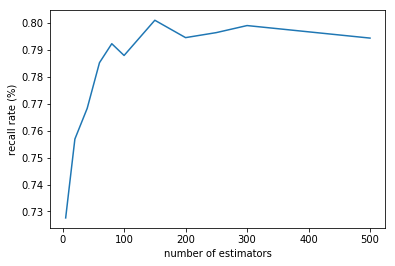

In [89]:
import matplotlib.pyplot as plt
plt.plot(e,p)
plt.xlabel('number of estimators')
plt.ylabel('recall rate (%)')
plt.savefig('estimators.png')
plt.show()

In [70]:
X.shape

(1005, 93)

In [97]:
ee = [1, 2, 5, 10, 20, 30, 50, 75, 90]
from sklearn.ensemble import RandomForestClassifier
pp = []
for eee in ee:
    pp.append(print_results(X, y, RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, max_features=eee), 'ensemble'))

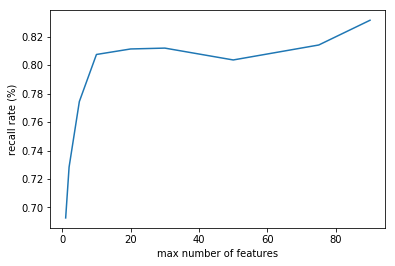

In [98]:
import matplotlib.pyplot as plt
plt.plot(ee,pp)
plt.xlabel('max number of features')
plt.ylabel('recall rate (%)')
plt.savefig('features.png')
plt.show()

In [121]:
clff = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2)
print_results(X, y, clff, 'hi')

hi
accuracy                0.8547263681592039 

percent detected        0.6392694566130233 

percent false alarm     0.145273631840796 

percent detected saline 0.4768809523809524
percent detected rubber 0.6853304166122502
percent detected clay   0.7976098901098901





0.6392694566130233